<a href="https://colab.research.google.com/github/jdasam/mas1004-2022/blob/main/notebooks/Data_AI_11th_week_Movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering with MovieLens Dataset

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [2]:
torch.set_printoptions(sci_mode=False)

In [3]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2022-11-15 06:02:29--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.58MB/s    in 0.2s    

2022-11-15 06:02:30 (4.58 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [4]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [100]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

In [6]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [7]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [8]:
class RatingSet:
  def __init__(self, csv_path='ml-latest-small/ratings.csv'):
    self.ratings = pd.read_csv(csv_path)

    # how many unique users exist in this dataset
    self.n_users = len(set(self.ratings['userId']))
    self.n_movies = len(set(self.ratings['movieId']))

    # list the every ids of included users
    self.user_ids = list(set(self.ratings['userId']))
    self.movie_ids = sorted(list(set(self.ratings['movieId'])))

    # we have to find in which idx the given movieId exists in this dataset's movie ID
    self.movie2idx = {id: idx for idx, id in enumerate(self.movie_ids)}
    self.user2idx = {id: idx for idx, id in enumerate(self.user_ids)}

  def __len__(self):
    return len(self.ratings) # number of ratings in the dataset

  def __getitem__(self, idx):
    idx_row = self.ratings.iloc[idx]

    user_id = self.user2idx[idx_row.userId]
    movie_id = self.movie2idx[idx_row.movieId]
    rating = idx_row.rating

    return user_id, movie_id, rating


dataset = RatingSet()
# set(dataset.ratings['userId'])
dataset.ratings
# dataset.movie_ids.index(1019)
# dataset.movie2idx[1019], dataset.movie_ids[777]
dataset[5000]

(31, 630, 4.0)

In [9]:
# indexing pandas DataFrame in a row
dataset.ratings.iloc[0]

userId               1.0
movieId              1.0
rating               4.0
timestamp    964982703.0
Name: 0, dtype: float64

In [16]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

batch = next(iter(dataloader))
batch

[tensor([231, 593, 534, 437]),
 tensor([7215,    1, 2030, 1083]),
 tensor([3.5000, 4.0000, 4.0000, 5.0000], dtype=torch.float64)]

In [57]:
class MatrixFactorizer(nn.Module):
  def __init__(self, n_user, n_movie, n_factor):
    super().__init__()

    self.user_embedding = nn.Embedding(n_user, n_factor)
    self.movie_embedding = nn.Embedding(n_movie, n_factor)
  
  def forward(self, user_id, movie_id):
    user_emb_vec = self.user_embedding(user_id)
    movie_emb_vec = self.movie_embedding(movie_id)

    elem_wise_multiplication_result = user_emb_vec * movie_emb_vec
    dot_prod_result = elem_wise_multiplication_result.sum(dim=1)

    return dot_prod_result.sigmoid() * 5.5


model = MatrixFactorizer(dataset.n_users, dataset.n_movies, n_factor=5)
model.movie_embedding.weight

model(batch[0], batch[1])

tensor([2.9371, 4.1273, 1.7889, 1.1646], grad_fn=<MulBackward0>)

In [12]:
# making prediction for given user and movie Id
user_id, movie_id, rating = dataset[0]

user_id = torch.tensor(user_id)
movie_id = torch.tensor(movie_id)

# call the embedding of corresponding user and movie
user_emb_vec = model.user_embedding(user_id)
movie_emb_vec = model.movie_embedding(movie_id)

# get dot product result
# user_emb_vec, movie_emb_vec, (user_emb_vec * movie_emb_vec)
# dot_result = (user_emb_vec * movie_emb_vec).sum()

dot_result = torch.matmul(user_emb_vec, movie_emb_vec)
dot_result

tensor(2.1247, grad_fn=<DotBackward0>)

In [22]:
user_id, movie_id, rating = batch

user_emb_vec = model.user_embedding(user_id)
print(user_id)
print(user_emb_vec)
movie_emb_vec = model.movie_embedding(movie_id)
print(movie_id)
print(movie_emb_vec)


print(user_emb_vec.shape, movie_emb_vec.shape)
elem_wise_multiplication_result = user_emb_vec * movie_emb_vec
print(elem_wise_multiplication_result)
# (user_emb_vec * movie_emb_vec).sum(dim=-1)
dot_prod_result = elem_wise_multiplication_result.sum(dim=1)
print(dot_prod_result)

tensor([231, 593, 534, 437])
tensor([[-0.5078, -1.4003,  0.6654,  0.9170, -0.1891],
        [ 0.3132, -1.1083,  0.3336, -0.5979,  1.0519],
        [ 0.1561, -0.0753, -0.2765,  0.7679, -0.8155],
        [-2.0426,  1.1159,  0.0204,  1.5418,  0.8248]],
       grad_fn=<EmbeddingBackward0>)
tensor([7215,    1, 2030, 1083])
tensor([[-0.5543, -1.5763, -1.9522, -0.1086, -1.0023],
        [-0.1738,  0.0979, -1.7814, -0.1503, -0.7222],
        [-0.1205, -0.2660, -1.2342, -0.1237, -0.9949],
        [-0.6583, -0.5397, -0.4097,  1.8889,  0.1956]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 5]) torch.Size([4, 5])
tensor([[ 0.2814,  2.2073, -1.2989, -0.0996,  0.1896],
        [-0.0545, -0.1085, -0.5942,  0.0899, -0.7597],
        [-0.0188,  0.0200,  0.3413, -0.0950,  0.8114],
        [ 1.3446, -0.6022, -0.0084,  2.9124,  0.1613]], grad_fn=<MulBackward0>)
tensor([ 1.2798, -1.4270,  1.0589,  3.8077], grad_fn=<SumBackward1>)


In [ ]:
# now our model takes two index values, and returns one float value
# input: index of user id, index of movie id
# output: rating of the movie by the user, in float value 

In [42]:
dot_prod_result, rating

(tensor([ 1.2798, -1.4270,  1.0589,  3.8077], grad_fn=<SumBackward1>),
 tensor([3.5000, 4.0000, 4.0000, 5.0000], dtype=torch.float64))

In [48]:
def cal_mse_loss(pred, target):
  # mean square error (mse)
  return ((pred-target)**2).mean()
  error = pred - target
  square_error = error ** 2
  # mean_square_error = error.mean()
  mean_square_error = square_error.sum() / error.numel()

  return mean_square_error

cal_mse_loss(dot_prod_result, rating)

tensor(11.1135, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [14]:

emb_test = nn.Embedding(num_embeddings=12, embedding_dim=5)
emb_test.weight


Parameter containing:
tensor([[-1.9009,  1.5295, -0.0744, -1.0810,  0.8321],
        [ 0.4841, -1.7811, -0.2373, -0.4492,  0.6521],
        [ 0.3746, -0.2084, -0.1802,  0.3934, -0.4702],
        [-1.2855,  0.7170, -0.7987,  0.1275,  0.4753],
        [ 0.3791, -0.1344, -0.3487,  0.5873,  1.0321],
        [ 0.6050,  0.8470, -0.5905, -2.5690,  1.3248],
        [ 0.1319,  0.5118,  1.3098, -0.0279,  1.2389],
        [ 0.3450,  1.5345,  1.0448, -0.3620, -0.0634],
        [-1.0642,  0.8620, -0.3022, -1.1927,  0.0249],
        [ 0.8337, -0.2052, -0.9458, -1.6306, -0.1189],
        [-0.4470, -0.8394, -0.8870,  1.1037, -0.5139],
        [ 0.3154, -1.0735,  0.5543,  1.6505,  0.1620]], requires_grad=True)

In [15]:
test_ids = torch.tensor([5,8,1,0])
emb_test(test_ids)

tensor([[ 0.6050,  0.8470, -0.5905, -2.5690,  1.3248],
        [-1.0642,  0.8620, -0.3022, -1.1927,  0.0249],
        [ 0.4841, -1.7811, -0.2373, -0.4492,  0.6521],
        [-1.9009,  1.5295, -0.0744, -1.0810,  0.8321]],
       grad_fn=<EmbeddingBackward0>)

# Training a model
- Train model with `Trainer` class
  - This is from the Assignment 2
- Now the task is regression
  - We are estimating the raiting in a continous value
- We have to split dataset into train / valid / test

In [25]:
dataset.ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [26]:
# split dataset into train / valid / test 
num_train = int(len(dataset)*0.8)
num_valid = int(len(dataset)*0.1)
num_test = len(dataset) - num_train - num_valid
print(len(dataset), num_train, num_valid, num_test)
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, 
                                              [num_train, num_valid, num_test])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

100836 80668 10083 10085


In [27]:
type(train_set)

torch.utils.data.dataset.Subset

In [30]:
# torch.utils.data.dataset.Subset class has attribute called indices
train_set.indices[:10]

[86412, 35393, 34195, 87257, 32174, 93357, 62744, 49215, 58876, 79745]

In [35]:
train_set[0], dataset[86412], train_set.dataset[train_set.indices[0]]

((559, 6211, 2.5), (559, 6211, 2.5), (559, 6211, 2.5))

In [68]:
class Trainer:
  def __init__(self, model, train_loader, valid_loader, model_name='resnet'):
    self.model = model
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.model.to(self.device)
    self.criterion = cal_mse_loss
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
    self.best_loss = torch.inf
    self.best_acc = 0.0
    self.train_losses = []
    self.valid_losses = []
    self.train_accs = []
    self.valid_accs = []
    self.model_name = model_name

  def validation(self):
    self.model.eval() # change the model from train mode to evaluation mode
    # Some models work in different ways based on whtehter it is on training step
    # or on inference step

    # In validation step, you don't have to calculate the gradient
    # with torch.no_grad():

    current_loss = 0
    num_total_correct_pred = 0
    with torch.inference_mode(): # every torch computation under this indent
    # will be run without calculating the gradient or computation history
      for batch in self.valid_loader:
        user_ids, movie_ids, ratings = batch
        # images, labels = images.to(self.device), labels.to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(user_ids, movie_ids) 

        loss = self.criterion(outputs, ratings) # you have to feed log_probs

        num_acc_pred = (torch.abs(outputs - ratings) < 0.5).sum()
        # num_acc_pred = (predicted_classes == labels.to(self.device)).sum()
        #num_acc_pred is on self.device
        num_total_correct_pred += num_acc_pred.item()
        # in validation stage, we don't care about single batch's loss
        # we want to see the result for total images of validation set

        current_loss += loss.item() * len(ratings)
        # instead of adding the mean loss, we add sum of loss
        # because the batch size can be different
    mean_loss = current_loss / len(self.valid_loader.dataset)
    mean_acc = num_total_correct_pred / len(self.valid_loader.dataset) # number of total datasample in the validation loader
    return mean_loss, mean_acc
    # return {'loss': mean_loss, 'acc': mean_acc}



  def train_by_number_of_epochs(self, num_epochs):
    for epoch in tqdm(range(num_epochs)):
      self.model.train()
      for batch in tqdm(self.train_loader, leave=False):
        # images, labels = batch
        user_ids, movie_ids, ratings = batch
        # images, labels = images.to(self.device), labels.to(self.device)
        self.optimizer.zero_grad()
        outputs = self.model(user_ids, movie_ids) 

        loss = self.criterion(outputs, ratings) # you have to feed log_probs

        acc = (torch.abs(outputs - ratings) < 0.5).sum() / len(ratings)
        # for torch.nn.NLLLoss
        loss.backward()
        self.optimizer.step()

        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
        # don't try self.train_losses.append(loss)
      # training step has ended
      # we want to test our model on the validation set
      valid_loss, valid_acc = self.validation()

      # is this model the best? 
      # let's decide it based on valid_acc
      if valid_acc > self.best_acc:
        self.best_acc = valid_acc

        # If it is the best model, save the model's weight'
        models_parameters = self.model.state_dict()
        print(f"Saving best model at epoch {len(self.valid_accs)}, acc: {valid_acc}")
        torch.save(models_parameters, f'{self.model_name}_best.pt')

      self.valid_losses.append(valid_loss)
      self.valid_accs.append(valid_acc)

    # Plot Accuracy curve
    plt.plot(self.train_accs)
    plt.plot(range(len(self.train_loader)-1, len(self.train_accs), len(self.train_loader)) ,self.valid_accs)
    plt.title("Accuracy")



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/631 [00:00<?, ?it/s]

Saving best model at epoch 0, acc: 0.12843399781810969


  0%|          | 0/631 [00:00<?, ?it/s]

Saving best model at epoch 1, acc: 0.13438460775562827


  0%|          | 0/631 [00:00<?, ?it/s]

Saving best model at epoch 2, acc: 0.13884756520876723


ValueError: ignored

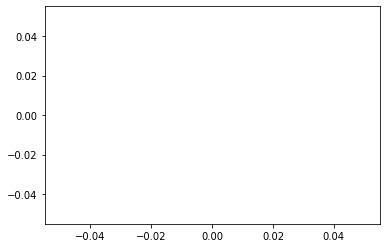

In [80]:
model = MatrixFactorizerWithBias(dataset.n_users, dataset.n_movies, n_factor=20)
trainer = Trainer(model, train_loader, valid_loader)
trainer.train_by_number_of_epochs(3)

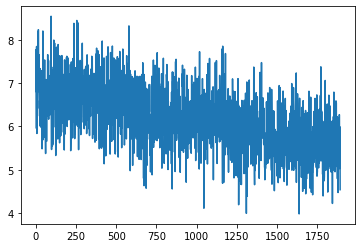

In [81]:
plt.plot(trainer.train_losses)

In [78]:
class MatrixFactorizerWithBias(MatrixFactorizer):
  def __init__(self, n_user, n_movie, n_factor):
    super().__init__(n_user, n_movie, n_factor)
    self.user_bias = nn.Embedding(n_user, 1)
    self.movie_bias = nn.Embedding(n_movie, 1)

  def forward(self, user_id, movie_id):
    user_emb_vec = self.user_embedding(user_id)
    movie_emb_vec = self.movie_embedding(movie_id)

    elem_wise_multiplication_result = user_emb_vec * movie_emb_vec
    dot_prod_result = elem_wise_multiplication_result.sum(dim=1)
    dot_prod_result += self.user_bias(user_id)[:, 0] + self.movie_bias(movie_id)[:, 0]

    return dot_prod_result.sigmoid() * 5.5


model = MatrixFactorizerWithBias(dataset.n_users, dataset.n_movies, n_factor=5)
model.movie_embedding.weight

model(batch[0], batch[1])

tensor([2.3650, 3.7960, 0.0696, 2.6069], grad_fn=<MulBackward0>)

In [ ]:
model.user_bias.weight

In [67]:
# Get accuracy function
test_batch = next(iter(test_loader))

user_ids, movie_ids, ratings = test_batch
pred = model(user_ids, movie_ids)
is_correct_pred = torch.abs(pred - ratings) < 0.5
is_correct_pred.sum()

tensor(22)

## Inference (test)
- Estimating a score for given User ID and Movie ID

## Cosine Similarity
- We can calculate similarity between two embeddings by using Cosine Similarity
  - $\text{cosine similarity} = \frac{\textbf{A}\cdot \textbf{B}}{\|\textbf{A}\|\|\textbf{B}\|} = \frac{\sum_{i=1}^{n}A_iB_i}{\sqrt{\sum_{i=1}^nA_i^2}\sqrt{\sum_{i=1}^nB_i^2}}$ 

In [83]:
def get_cosine_similarity_of_two_movie(model, id_a, id_b):
  emb = model.movie_embedding.weight
  emb_a = emb[id_a]
  emb_b = emb[id_b]

  dot_prod = (emb_a * emb_b).sum()
  len_a = (emb_a**2).sum().sqrt()
  len_b = (emb_b**2).sum().sqrt()

  return dot_prod / (len_a * len_b)

get_cosine_similarity_of_two_movie(model, 0, 2)

tensor(-0.0321, grad_fn=<DivBackward0>)

In [104]:
id_a = 0
# def get_most_similar_movies_for_given_id(model, id_a):
emb = model.movie_embedding.weight
emb_a = emb[id_a]

dot_prod = (emb_a * emb).sum(dim=1)
len_a = (emb_a**2).sum().sqrt()
len_b = (emb**2).sum(dim=1).sqrt()

cos_sim = dot_prod / (len_a * len_b)
cos_sim[id_a] = 0
id_in_sorted = torch.argsort(cos_sim, descending=True)

ref_id = dataset.movie_ids[id_a]
movies[movies['movieId'] == ref_id]
movies[movies['movieId'] == dataset.movie_ids[id_in_sorted[0]]]


,movieId,title,genres
8547,115664,The Book of Life (2014),Adventure|Animation|Romance


In [97]:
cos_sim[8529]

tensor(0.7119, grad_fn=<SelectBackward0>)

# Visualization of Embedding

In [ ]:
!pip install -q umap-learn
!pip install -Uq plotly

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

def get_umap_embedding(embedding, n_reduced_dimension=2, n_neighbors=15):
  reducer = umap.UMAP(n_components=n_reduced_dimension, n_neighbors=n_neighbors)
  umap_emb = reducer.fit_transform(embedding)
  return umap_emb

def make_scatter3d(emb, label):
  trace = go.Scatter3d(
    x=emb[:,0],  
    y=emb[:,1],  
    z=emb[:,2], 
    mode='markers',
    marker={
        'size': 2,
        'opacity': 0.5,
    },
    text = label,
  )
  return trace

def make_3d_plot_with_pyplot(embs, labels, highlighted_titles):
  highlighted_indices = [labels.index(title) if title in labels else 0 for title in highlighted_titles]
  layout = go.Layout(
      margin={'l': 0, 'r': 0, 'b': 0, 't': 0},
      scene=dict(
          annotations = [dict(x=embs[i,0], y=embs[i,1], z=embs[i,2],text=labels[i]) for i in highlighted_indices ]
      )
  )
  data = make_scatter3d(embs,labels)
  plot_figure = go.Figure(data=data, layout=layout)
  plot_figure.update_traces(textposition='top center')
  plot_figure.show(renderer="colab")
